In [1]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy import func
import pandas as pd
import matplotlib
matplotlib.use('nbagg')
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
engine = create_engine('sqlite:///test.sqlite')
Base = automap_base()
Base.prepare(engine, reflect = True)
session = Session(bind=engine)

In [3]:
Base.classes.keys()

['measurement', 'stations']

In [4]:
Base.metadata.tables

immutabledict({'measurement': Table('measurement', MetaData(bind=None), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', VARCHAR(), table=<measurement>), Column('date', VARCHAR(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', INTEGER(), table=<measurement>), schema=None), 'stations': Table('stations', MetaData(bind=None), Column('id', INTEGER(), table=<stations>, primary_key=True, nullable=False), Column('station', VARCHAR(), table=<stations>), Column('name', VARCHAR(), table=<stations>), Column('latitude', FLOAT(), table=<stations>), Column('longitude', FLOAT(), table=<stations>), Column('elevation', FLOAT(), table=<stations>), schema=None)})

### Precipitation Analysis

* Design a query to retrieve the last 12 months of precipitation data.

* Select only the `date` and `prcp` values.

* Load the query results into a Pandas DataFrame and set the index to the date column.

* Plot the results using the DataFrame `plot` method

In [5]:
Measurement = Base.classes.measurement
Station = Base.classes.stations

In [6]:
session = Session(bind=engine)

In [7]:
prcp_data = session.query(Measurement).first()
prcp_data.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x21c44993400>,
 'date': '2010-01-01',
 'id': 0,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65}

In [8]:
df = pd.DataFrame(session.query(Measurement.station,
                                Measurement.date,
                                Measurement.prcp,
                                Measurement.tobs).all())
df.head()

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-07,0.06,70


In [9]:
prcp_analysis_df = df[['date', 'prcp']]
prcp_analysis_df.head()

,date,prcp
0,2010-01-01,0.08
1,2010-01-02,0.00
2,2010-01-03,0.00
3,2010-01-04,0.00
4,2010-01-07,0.06


In [10]:
prcp_year_df = prcp_analysis_df[(prcp_analysis_df['date'] > '2016-08-23') & (prcp_analysis_df['date'] <= '2017-08-23')]
prcp_year_df = prcp_year_df.sort_values(by='date')

In [12]:
prcp_year_df.head()

,date,prcp
2327,2016-08-24,0.08
10602,2016-08-24,1.22
7054,2016-08-24,2.28
17776,2016-08-24,1.45
5039,2016-08-24,2.15


In [14]:
df.head()

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-07,0.06,70


<IPython.core.display.Javascript object>


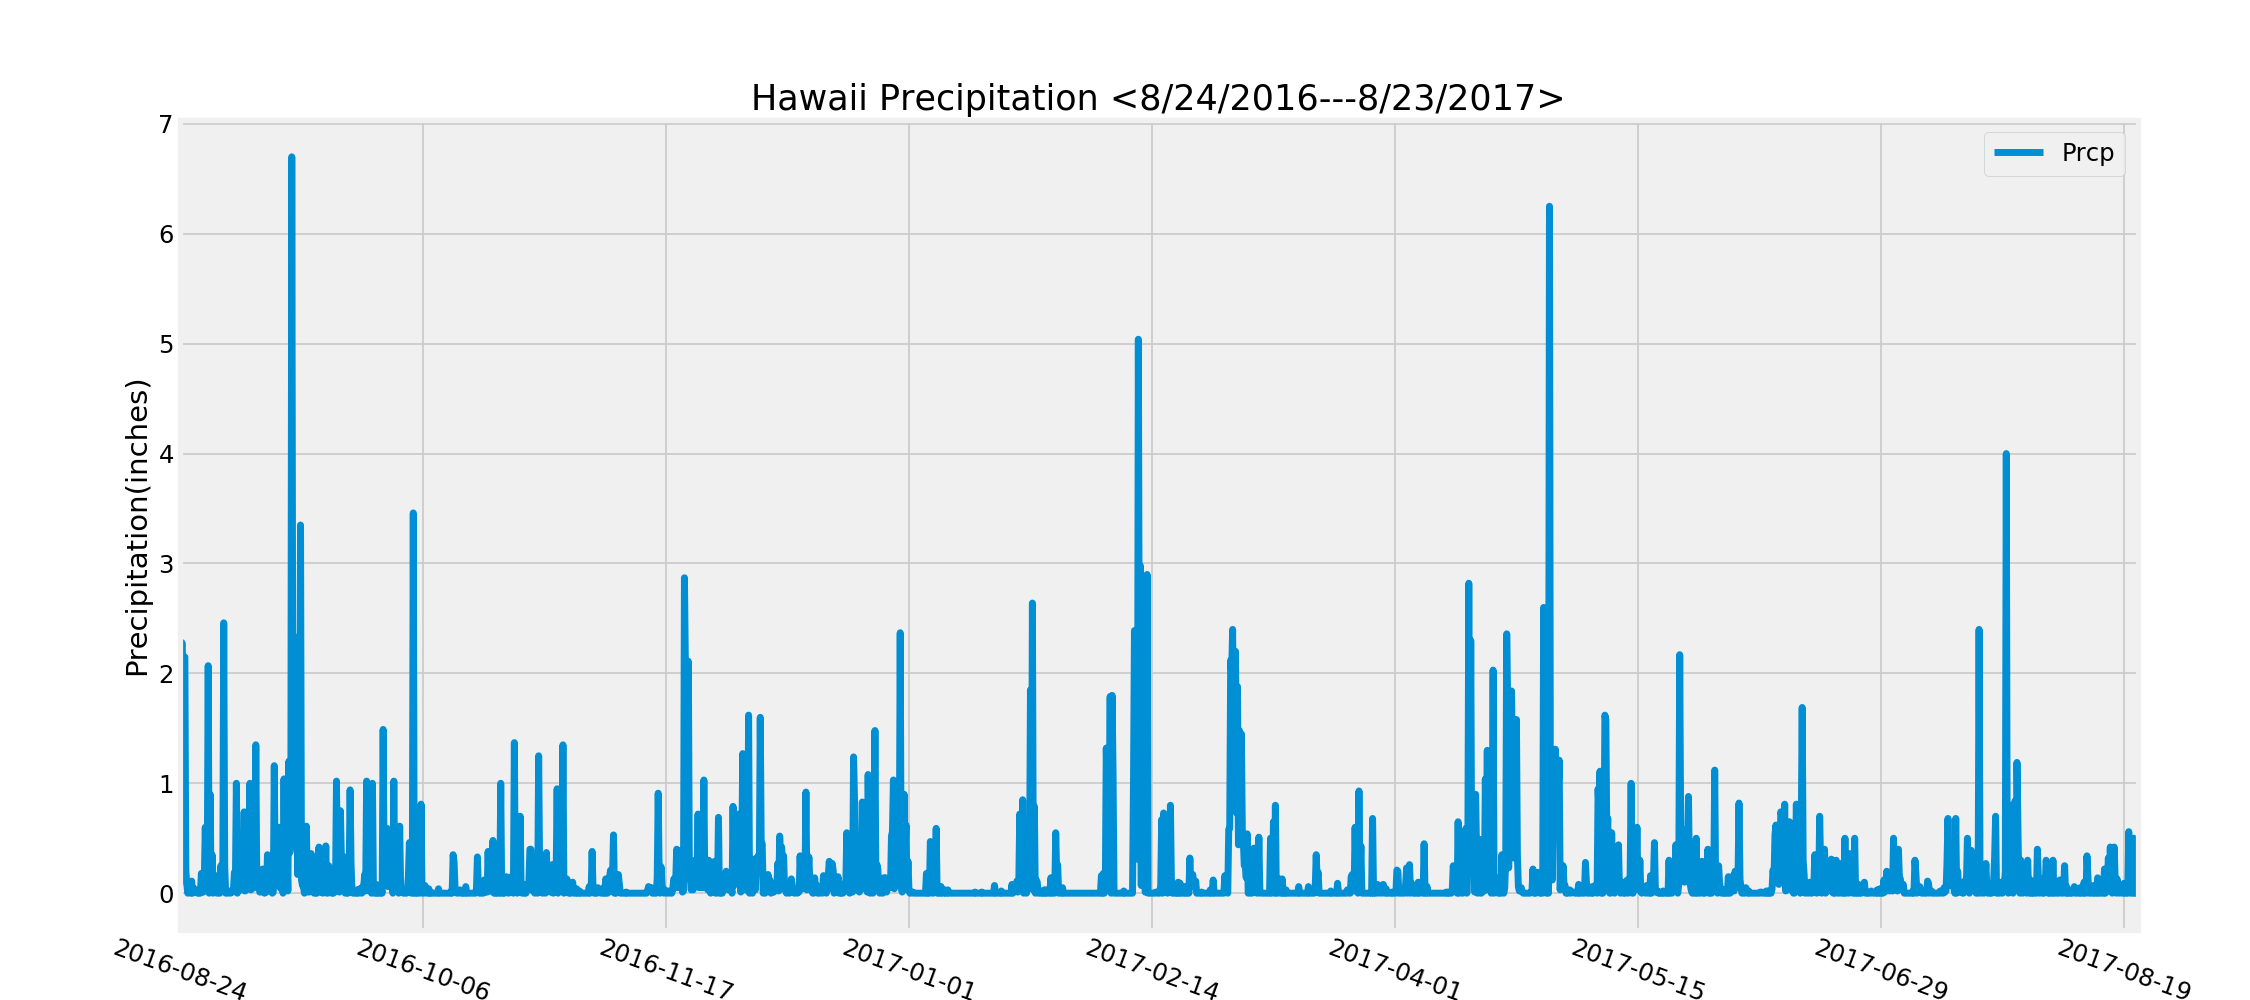

In [19]:
prcp_year_df.plot(x='date', figsize = (18,8), rot = 340)
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Precipitation(inches)")
plt.title("Hawaii Precipitation <8/24/2016---8/23/2017>")
plt.legend(["Prcp"])
plt.show()

In [20]:
prcp_year_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

* Design a query to calculate the total number of stations.

* Design a query to find the most active stations.

  * List the stations and observation counts in descending order

  * Which station has the highest number of observations?

* Design a query to retrieve the last 12 months of temperature observation data (tobs).

  * Filter by the station with the highest number of observations.

  * Plot the results as a histogram with `bins=12`.


In [39]:
#Design a query to calculate the total number of stations.
station_count = session.query(Station.station).count()
station_count

9

In [47]:
#Design a query to find the most active stations
Most_active = session.query(Station.station,
                            Station.name,
                            Measurement.station,
                            func.count(Measurement.tobs)
                           ).filter(Station.station == Measurement.station
                                   ).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

In [48]:
Most_active

[('USC00519281', 'WAIHEE 837.5, HI US', 'USC00519281', 2772),
 ('USC00513117', 'KANEOHE 838.1, HI US', 'USC00513117', 2696),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 'USC00519397', 2685),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 2572),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 'USC00516128', 2484),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  'USC00514830',
  1937),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 'USC00511918', 1932),
 ('USC00517948', 'PEARL CITY, HI US', 'USC00517948', 683),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 'USC00518838', 342)]

In [53]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
Top_active = Most_active[0][0:2]
Top_active

('USC00519281', 'WAIHEE 837.5, HI US')

In [61]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).

year_temp = session.query(Measurement.station,
                                       Measurement.tobs).filter(Measurement.station == Top_active[0], Measurement.date > '2016-08-23').all()
year_temp

[('USC00519281', 77),
 ('USC00519281', 80),
 ('USC00519281', 80),
 ('USC00519281', 75),
 ('USC00519281', 73),
 ('USC00519281', 78),
 ('USC00519281', 77),
 ('USC00519281', 78),
 ('USC00519281', 80),
 ('USC00519281', 80),
 ('USC00519281', 78),
 ('USC00519281', 78),
 ('USC00519281', 78),
 ('USC00519281', 73),
 ('USC00519281', 74),
 ('USC00519281', 80),
 ('USC00519281', 79),
 ('USC00519281', 77),
 ('USC00519281', 80),
 ('USC00519281', 76),
 ('USC00519281', 79),
 ('USC00519281', 75),
 ('USC00519281', 79),
 ('USC00519281', 78),
 ('USC00519281', 79),
 ('USC00519281', 78),
 ('USC00519281', 78),
 ('USC00519281', 76),
 ('USC00519281', 74),
 ('USC00519281', 77),
 ('USC00519281', 78),
 ('USC00519281', 79),
 ('USC00519281', 79),
 ('USC00519281', 77),
 ('USC00519281', 80),
 ('USC00519281', 78),
 ('USC00519281', 78),
 ('USC00519281', 78),
 ('USC00519281', 77),
 ('USC00519281', 79),
 ('USC00519281', 79),
 ('USC00519281', 79),
 ('USC00519281', 79),
 ('USC00519281', 75),
 ('USC00519281', 76),
 ('USC0051

In [62]:
temperature = [x[1] for x in year_temp]
temperature[0]

77

<IPython.core.display.Javascript object>


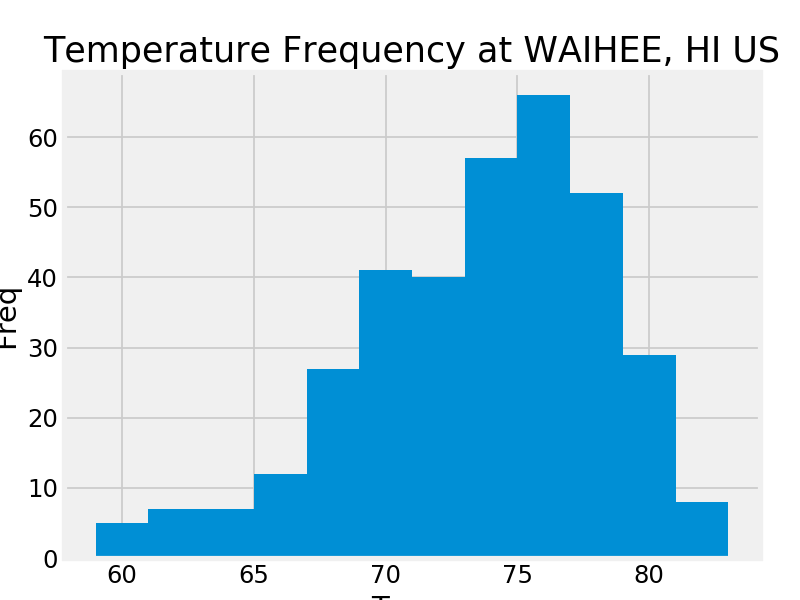

In [64]:
plt.hist(temperature, bins=12)
plt.title("Temperature Frequency at WAIHEE, HI US")
plt.grid(True)
plt.figsize = (18,8)
plt.xlabel("Temp")
plt.ylabel("Freq")
plt.show()

### Temperature Analysis

* Write a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d` and return the minimum, average, and maximum temperatures for that range of dates.

* Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")

* Plot the min, avg, and max temperature from your previous query as a bar chart.

  * Use the average temperature as the bar height.

  * Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).


In [71]:
temp_df = df[['date', 'prcp', 'tobs']]
prcp_df = temp_df[(prcp_analysis_df['date'] > '2016-08-23') & (prcp_analysis_df['date'] <= '2017-08-23')]
temp_year_df = prcp_df.sort_values(by='date')
temp_year_df.head()



,date,prcp,tobs
2327,2016-08-24,0.08,79
10602,2016-08-24,1.22,79
7054,2016-08-24,2.28,80
17776,2016-08-24,1.45,74
5039,2016-08-24,2.15,76


In [73]:
def calc_temps(starting_date, ending_date):
    temp = temp_year_df[(prcp_analysis_df['date'] > starting_date) & (prcp_analysis_df['date'] <= ending_date)]
    temp_max = temp.tobs.max()
    temp_min = temp.tobs.min()
    temp_mean = temp.tobs.mean()
    return (temp_max, temp_min, temp_mean)

temp_max, temp_min, temp_mean = calc_temps("2017-07-24", "2017-07-31")

C:\Users\HeeXPS\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [74]:
temp_max, temp_min, temp_mean


(84, 73, 79.0952380952381)

<IPython.core.display.Javascript object>


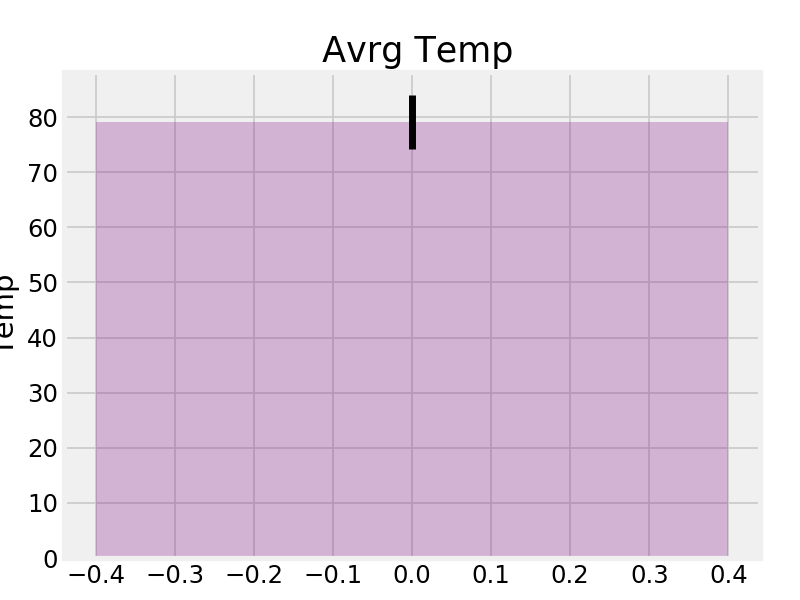

In [75]:
plt.bar(0, temp_mean, color='purple', alpha=.25, yerr=[temp_max - temp_mean])
plt.align = 'center'
plt.figsize = (18,8)
plt.grid(True)
plt.ylabel("Temp")
plt.title(" Avrg Temp")
plt.show()